In [66]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [67]:
import numpy as np
import pandas as pd

In [68]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [69]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [70]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [71]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [72]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [73]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [74]:
inspector = inspect(engine)

In [75]:
mes_columns = inspector.get_columns('measurement')
for c in mes_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [76]:
inspector = inspect(engine)


In [77]:
st_columns = inspector.get_columns('station')
for c in st_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [78]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [100]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [79]:
data = session.query(Station.station, Station.name).all()
for row in data:
    print(row)

('USC00519397', 'WAIKIKI 717.2, HI US')
('USC00513117', 'KANEOHE 838.1, HI US')
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US')
('USC00517948', 'PEARL CITY, HI US')
('USC00518838', 'UPPER WAHIAWA 874.3, HI US')
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US')
('USC00519281', 'WAIHEE 837.5, HI US')
('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US')
('USC00516128', 'MANOA LYON ARBO 785.2, HI US')


# Exploratory Climate Analysis

In [80]:

# Design a query to retrieve the last 12 months of precipitation data and plot the results

last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
myDate = datetime.strptime(last_date[0], "%Y-%m-%d") - dt.timedelta(days=365)

data = session.query(Measurement).filter(Measurement.date >= myDate)

conn = engine.connect()
df = pd.read_sql(str(data), conn, params=[(myDate)])
df = df.set_index('measurement_date', drop=True)

df = df.sort_values(by=['measurement_date'], ascending=True)
df.head()

,measurement_id,measurement_station,measurement_prcp,measurement_tobs
measurement_date,,,,
2016-08-24,2365,USC00519397,0.08,79.0
2016-08-24,8826,USC00517948,NaN,78.0
2016-08-24,14609,USC00519281,2.15,77.0
2016-08-24,7332,USC00514830,2.28,80.0
2016-08-24,5092,USC00513117,2.15,76.0


Text(0.5, 0, 'Date')

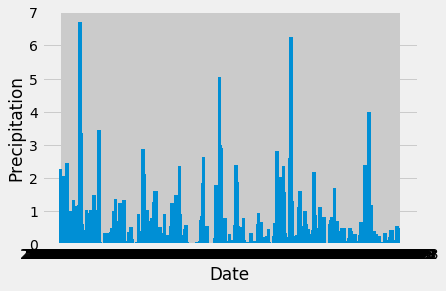

In [81]:

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots()
ax.bar(df.index, df['measurement_prcp'], width=4, tick_label=None)
ax.set_ylabel("Precipitation")
ax.set_xlabel("Date")

In [82]:

# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()['measurement_prcp']

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: measurement_prcp, dtype: float64

In [83]:
nStations = session.query(Station).count()
nStations

9

In [84]:
# Design a query to show how many stations are available in this dataset?
nStations = session.query(Station).count()
f"There are {nStations} Stations in this dataset"

'There are 9 Stations in this dataset'

In [85]:
from sqlalchemy import desc
nMeasurements = session.query(Measurement.station, func.count(Measurement.date)).\
group_by(Measurement.station).order_by(desc(func.count(Measurement.date))).first()
nMeasurements

('USC00519281', 2772)

In [87]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
myStation = nMeasurements[0]

In [90]:
my_station_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),\
                        func.avg(Measurement.tobs)).all()

In [91]:
my_station_stats

[(53.0, 87.0, 73.09795396419437)]

Text(0.5, 1.0, 'Temperature frequency at WAIHEE 837.5, HI US')

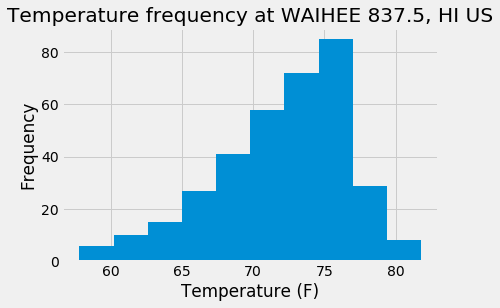

In [103]:
my_station_name = session.query(Station.name).filter(Station.station==myStation).all()[0][0]
temps = session.query(Measurement.tobs).filter(Measurement.station==myStation).filter(Measurement.date>myDate).all()
counts, bin_edges = np.histogram(temps)
plt.bar(x=bin_edges[0:-1], height=counts, width=2.4)
plt.ylabel("Frequency")
plt.xlabel("Temperature (F)")
plt.title(f"Temperature frequency at {my_station_name}")

In [111]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()


print(calc_temps('2017-05-25', '2017-05-30'))

[(69.0, 75.3529411764706, 82.0)]


In [121]:
tmin, tavg, tmax = calc_temps('2017-05-25', '2017-05-30')[0]
print(f"Minimum Temp: {tmin}, Average Temp: {round(tavg,1)}, Maximum Temp: {tmax}")

Minimum Temp: 69.0, Average Temp: 75.4, Maximum Temp: 82.0


Text(0.5, 1.0, 'Trip Aevage Temp')

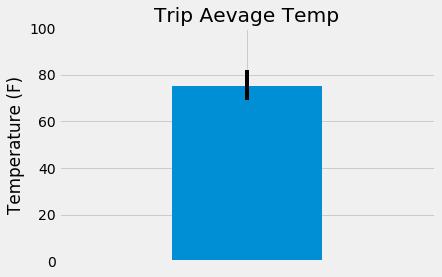

In [117]:
er = np.array([[tavg-tmin], [tmax-tavg]])
fig, ax = plt.subplots()
ax.bar(x=0, height=tavg, yerr=er, tick_label='')
ax.set_ylim([0, 100])
ax.set_xlim([-1, 1])
ax.set_ylabel("Temperature (F)")
ax.set_title("Trip Aevage Temp")

In [123]:
sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
rainfalls = session.query(*sel).group_by(Measurement.station).\
filter((Measurement.date > '2016-05-25') & (Measurement.date < '2016-05-30')).\
order_by(desc(func.sum(Measurement.prcp))).filter(Measurement.station == Station.station).all()
print(rainfalls)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 1.68), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 1.1900000000000002), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.8500000000000001), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.7000000000000001), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.4799999999999999), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.37), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]
